In [181]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import Matern, RationalQuadratic,ExpSineSquared,PairwiseKernel
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from sklearn.model_selection import KFold
import joblib

In [182]:
kernel_names = ["Matern","RationalQuadratic","ExpSineSquared","Laplace","RBF"]
cv_results_all_kernels = {}
for kernel_name in kernel_names:
    savepath = f"cv_results_{kernel_name}.pkl"
    cv_results = joblib.load(savepath)
    cv_results_all_kernels[kernel_name] = cv_results
#cv_results_all_kernels['Matern']

In [183]:
combinedkernels =["RBFMatkernel","RBFRadkernel","RBFLaplacekernel"]
##combinedkernels =["RBFMatkernel"]
combined_kernel_results = {}
for kernel_name in combinedkernels:
    savepath = f"cv_results_{kernel_name}.pkl"
    cv_results = joblib.load(savepath)
    combined_kernel_results[kernel_name] = cv_results
#combined_kernel_results


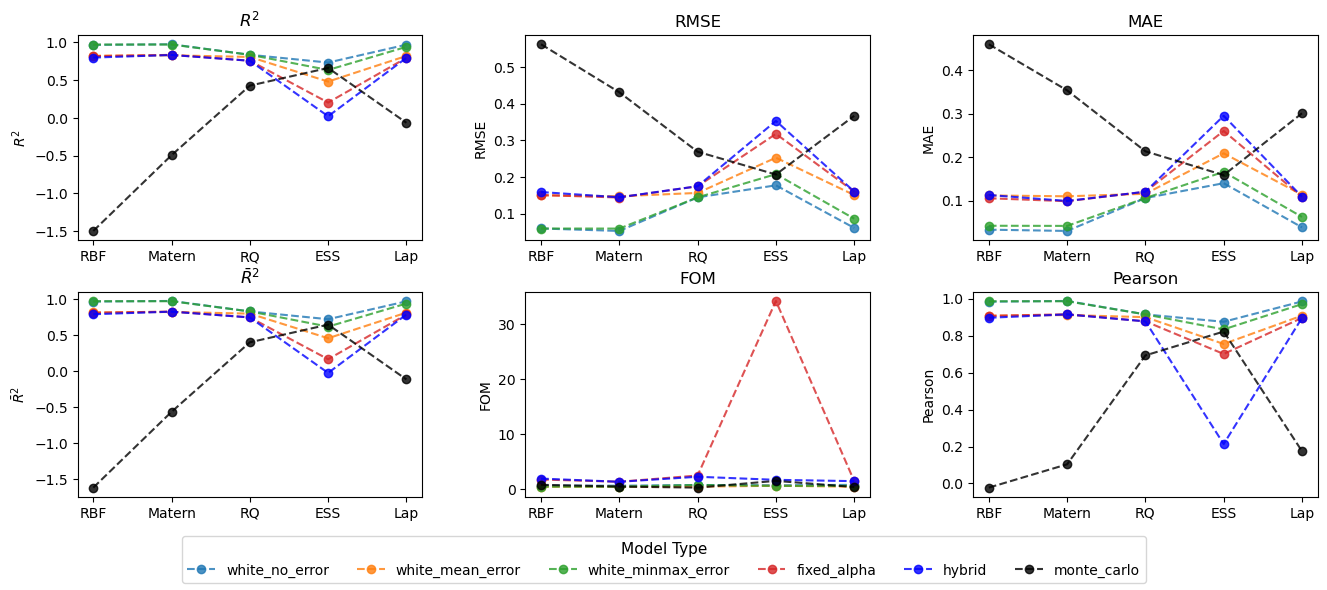

In [184]:
kernel_names = ['RBF', 'Matern', 'RationalQuadratic', 'ExpSineSquared', 'Laplace']
kernel_names_short = ['RBF', 'Matern', 'RQ', 'ESS', 'Lap']
modeltypes = ['white_no_error', 'white_mean_error','white_minmax_error','fixed_alpha','hybrid','monte_carlo']
metrics = ['r2', 'rmse', 'mae', 'adjusted_r2', 'fom', 'pearson']
metric_names = ['$R^2$', 'RMSE', 'MAE', '$\\bar{R}^2$', 'FOM', 'Pearson']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','blue','black']  # Colors for modeltypes (not kernels)



#print(cv_results_all_kernels['Matern']['white_no_error']['mae'])


# Plot setup: 2 rows, 3 columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 6), sharex=False, sharey=False)
axes = axes.flatten()
x_ticks = np.arange(len(kernel_names))

# Storage for legend handles/labels
lines = []
labels = []

# Loop over each metric (one subplot per metric)
for i, metric in enumerate(metrics):
    ax = axes[i]

    # Plot each model type
    for j, modeltype in enumerate(modeltypes):
        metric_values = [np.mean(cv_results_all_kernels[kernel][modeltype][metric]) for kernel in kernel_names]
        line, = ax.plot(x_ticks, metric_values, '--o', alpha =0.8, label=modeltype, color=colors[j])

        # Save one set of legend handles only (from first subplot)
        if i == 0:
            lines.append(line)
            labels.append(modeltype)
    # for combo_idx, (combo_name, combo_metrics) in enumerate(combined_kernel_results.items()):
    #     combo_colors = ["green", "purple", "grey"]
    #     y = np.mean(combo_metrics['combined_kernel'][metric])
    #     ax.axhline(y=y, color=combo_colors[combo_idx], linestyle='--', linewidth=1, label='combined_kernel' if i == 0 and combo_idx == 0 else "")
        
    ax.set_title(f'{metric_names[i]}')
    full_labels = kernel_names_short
    full_xticks = np.arange(len(full_labels))
    ax.set_xticks(full_xticks)
    ax.set_xticklabels(full_labels, fontsize=10)
    ax.set_ylabel(metric_names[i])

# Shared legend below all subplots
fig.legend(lines, labels, title="Model Type", loc='lower center', ncol=len(modeltypes), fontsize=10, title_fontsize=11)

# Adjust spacing for tighter layout and space for legend
plt.subplots_adjust(top=0.92, bottom=0.15, hspace=0.25,wspace=0.3)
plt.savefig(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Latex\LatexPlots\CV_plots\metrics_compared",dpi=72, bbox_inches='tight')
plt.show()

#### I need to add monte carlo sampling to this code ####

In [185]:
combined_kernels = {
    'RBFMat': combined_kernel_results['RBFMatkernel']['combined_kernel'],
    'RBFLaplace': combined_kernel_results['RBFLaplacekernel']['combined_kernel'],
    'RBFRad': combined_kernel_results['RBFRadkernel']['combined_kernel'],
}

kernel_names = ['RBF', 'Matern', 'RationalQuadratic', 'ExpSineSquared', 'Laplace']
modeltypes = ['white_no_error', 'white_mean_error', 'white_minmax_error','fixed_alpha']
metrics = ['r2', 'rmse', 'mae', 'adjusted_r2', 'fom', 'pearson']

models = []
for kernel in kernel_names:
    for modeltype in modeltypes:
        models.append((kernel, modeltype))

ranks = {metric: [] for metric in metrics}
        
# Add to models list
for combo_name in combined_kernels:
    models.append((combo_name, 'combined_kernel'))


# Update ranks dictionary
for metric in metrics:
    metric_values = []
    for kernel, modeltype in models:
        if modeltype == 'combined_kernel':
            kernel = kernel+'kernel'
            value = np.mean(combined_kernel_results[kernel]['combined_kernel'][metric])
        else:
            value = np.mean(cv_results_all_kernels[kernel][modeltype][metric])
        metric_values.append(value)

    metric_array = np.array(metric_values)

    # Decide ranking logic
    if metric in ['r2', 'adjusted_r2', 'pearson']:
        order = metric_array.argsort()[::-1]
    #elif metric == 'fom':
    #    order = np.abs(metric_array - 1).argsort()
    else:
        order = metric_array.argsort()

    # Assign ranks
    rank_array = np.empty_like(order)
    rank_array[order] = np.arange(1, len(order) + 1)
    ranks[metric] = rank_array

# === Build DataFrame ===
ranking_df = pd.DataFrame({
    'Kernel': [k for k, m in models],
    'Noise Model': [m for k, m in models]})

for metric in metrics:
    ranking_df[f'{metric.upper()} Rank'] = ranks[metric]

# Compute average rank from all metric ranks
ranking_df['Average Rank'] = ranking_df[[f'{m.upper()} Rank' for m in metrics]].mean(axis=1)

# Sort by Average Rank first, then by R2 Rank as a tie-breaker
ranking_df = ranking_df.sort_values(by=['Average Rank', 'R2 Rank'], ascending=[True, True]).reset_index(drop=True)

# Assign unique Final Ranks (no ties)
ranking_df['Final Rank'] = np.arange(1, len(ranking_df) + 1)

# Display updated table
print("\nFinal Model Ranking Including Combined Kernels:\n")
print(ranking_df)


Final Model Ranking Including Combined Kernels:

               Kernel         Noise Model  R2 Rank  RMSE Rank  MAE Rank  \
0              RBFMat     combined_kernel        1          1         1   
1              Matern      white_no_error        2          2         2   
2              Matern  white_minmax_error        3          3         6   
3                 RBF  white_minmax_error        4          4         7   
4                 RBF      white_no_error        7          5         3   
5             Laplace      white_no_error        5          6         4   
6          RBFLaplace     combined_kernel        6          7         5   
7             Laplace  white_minmax_error        8          8         8   
8              RBFRad     combined_kernel        9          9         9   
9              Matern    white_mean_error       13         13        15   
10  RationalQuadratic  white_minmax_error       10         11        12   
11             Matern         fixed_alpha       12


Pairwise Metric Distance Matrix:
                 r2   rmse    mae  adjusted_r2    fom  pearson
r2           0.000  0.007  0.050        0.000  0.740    0.004
rmse         0.007  0.000  0.037        0.007  0.758    0.006
mae          0.050  0.037  0.000        0.050  0.934    0.046
adjusted_r2  0.000  0.007  0.050        0.000  0.740    0.004
fom          0.740  0.758  0.934        0.740  0.000    0.746
pearson      0.004  0.006  0.046        0.004  0.746    0.000


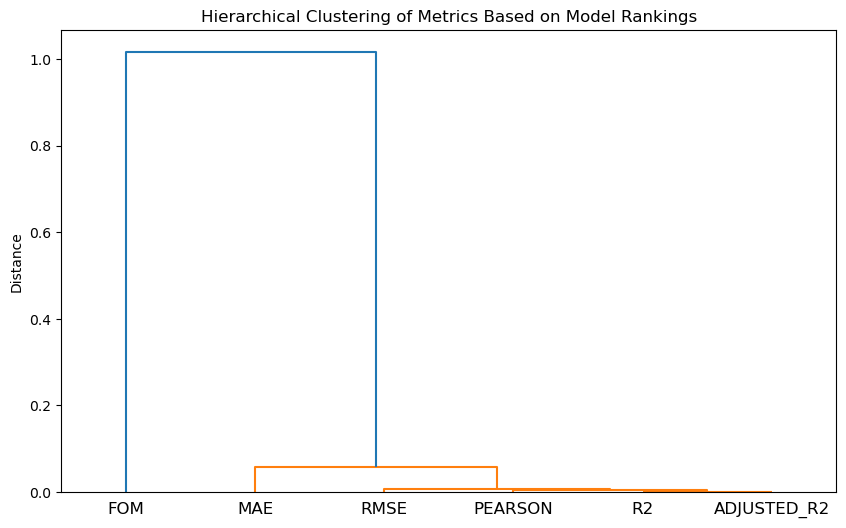

In [186]:
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

# Assuming 'ranking_df' is your final DataFrame from your code
# and contains columns like 'R2 Rank', 'RMSE Rank', etc.

# Step 1: Extract rank data for each metric across models
metrics = ['r2', 'rmse', 'mae', 'adjusted_r2', 'fom', 'pearson']
rank_columns = [f'{metric.upper()} Rank' for metric in metrics]

# (n_models, n_metrics) matrix
rank_matrix = ranking_df[rank_columns].values.T  # shape: (n_metrics, n_models)

distance_matrix = pdist(rank_matrix, metric='correlation')  # Correlation (1 - corr)

# Optional: See the pairwise distance matrix
distance_square = squareform(distance_matrix)
distance_df = pd.DataFrame(distance_square, index=metrics, columns=metrics)
print("\nPairwise Metric Distance Matrix:\n", distance_df.round(3))

# Step 3: Perform hierarchical clustering
linkage_matrix = linkage(distance_matrix, method='ward')  # 'ward' for variance minimization

# Step 4: Plot dendrogram
fig, ax = plt.subplots(figsize=(10, 6)) 
dendrogram(
    linkage_matrix,
    labels=[metric.upper() for metric in metrics],
    leaf_rotation=0,
    leaf_font_size=12,
    color_threshold=None,  # Adjust or leave None to color everything
)
ax.set_title("Hierarchical Clustering of Metrics Based on Model Rankings")
ax.set_ylabel("Distance")
plt.savefig(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Latex\LatexPlots\CV_plots\clustermetrics",dpi=72, bbox_inches='tight')
plt.show()

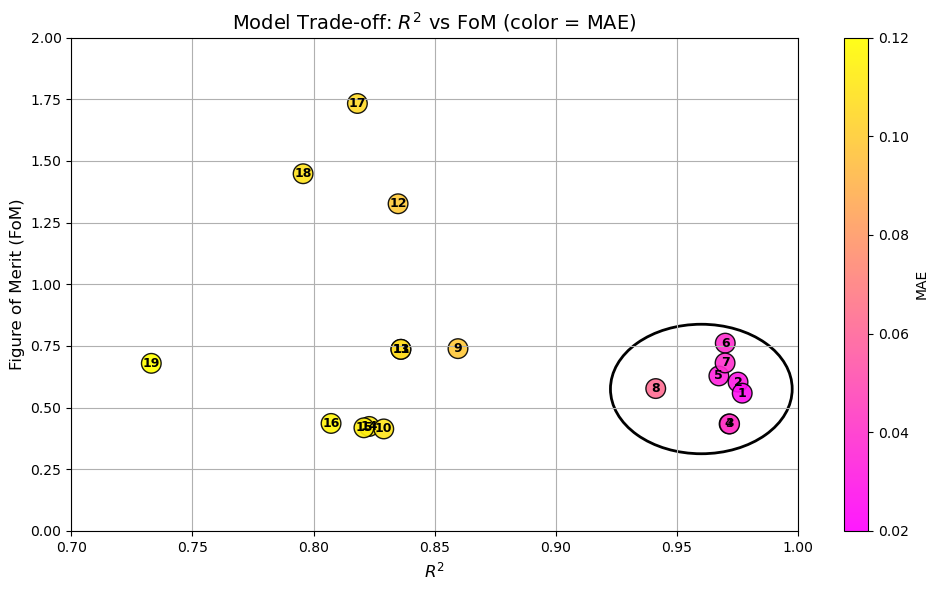

In [187]:
from matplotlib.patches import Circle
# --- Create a mapping from each (kernel, modeltype) to its final rank ---
rank_mapping = {(row['Kernel'], row['Noise Model']): row['Final Rank']
                for _, row in ranking_df.iterrows()}

r2_list = []
fom_list = []
mae_list = []
vmin = 0.02
vmax = 0.12



for kernel, modeltype in models:
    if modeltype == 'combined_kernel':
        r2_list.append(np.mean(combined_kernels[kernel]['r2']))
        fom_list.append(np.mean(combined_kernels[kernel]['fom']))
        mae_list.append(np.mean(combined_kernels[kernel]['mae']))
    else:
        r2_list.append(np.mean(cv_results_all_kernels[kernel][modeltype]['r2']))
        fom_list.append(np.mean(cv_results_all_kernels[kernel][modeltype]['fom']))
        mae_list.append(np.mean(cv_results_all_kernels[kernel][modeltype]['mae']))

r2_array = np.array(r2_list)
fom_array = np.array(fom_list)
mae_array = np.array(mae_list)

# --- Scatter plot ---
fig, ax = plt.subplots(figsize=(10, 6)) 
scatter = ax.scatter(r2_array, fom_array, c=mae_array, cmap='spring', s=200,edgecolor='k', alpha=0.9, vmin=vmin, vmax=vmax)

# Annotate each point with its final ranking (from ranking_df)
for i, (kernel, modeltype) in enumerate(models):
    ax.annotate(str(rank_mapping[(kernel, modeltype)]), (r2_array[i], fom_array[i]),fontsize=9, weight='bold', ha='center', va='center')

from matplotlib.patches import Ellipse

# Example: Center at (0.96, 0.65), with width and height of the ellipse
ellipse = Ellipse((0.96, 0.575), width=0.075, height=0.525,
                  edgecolor='black', fill=False, linewidth=2)
ax.add_patch(ellipse)

# Plot formatting
ax.set_xlabel('$R^2$', fontsize=12)
ax.set_ylabel('Figure of Merit (FoM)', fontsize=12)
ax.set_title('Model Trade-off: $R^2$ vs FoM (color = MAE)', fontsize=14)
#ax.axhline(1, color='red', linestyle='--', label='FoM = 1')
ax.set_ylim((0, 2))
ax.set_xlim((0.7, 1))
ax.grid(True)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('MAE')

plt.tight_layout()
plt.savefig(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Latex\LatexPlots\CV_plots\r2vsfom",dpi=72, bbox_inches='tight')
plt.show()


C:\Users\seanw\AppData\Local\Temp\ipykernel_1208\4126735525.py:50: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=0.1)


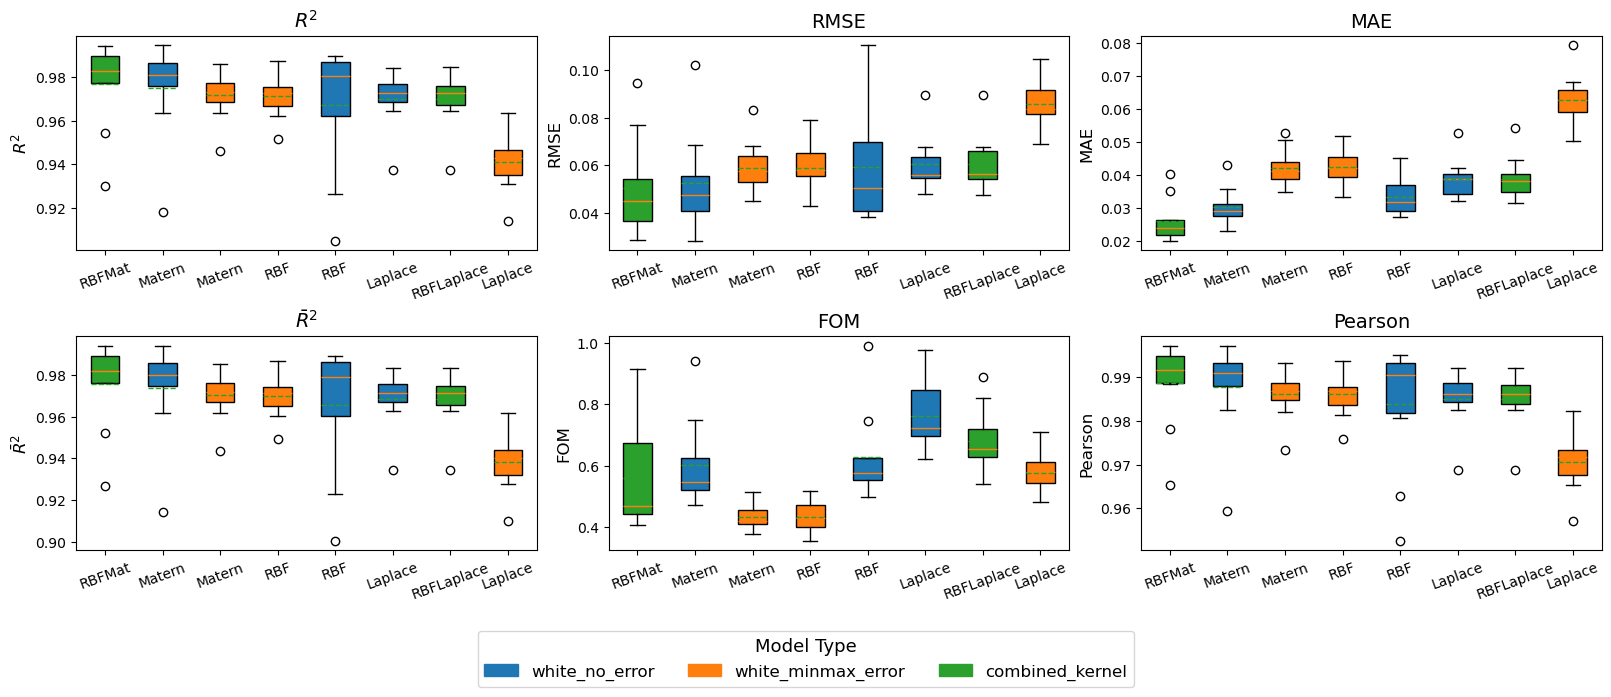

In [188]:
top_5_models = ranking_df[ranking_df['Final Rank'].isin([3,5,6,2,1,8,4,7])]

# Metrics and styles
metrics = ['r2', 'rmse', 'mae', 'adjusted_r2', 'fom', 'pearson']
metric_names = ['$R^2$', 'RMSE', 'MAE', '$\\bar{R}^2$', 'FOM', 'Pearson']
colors = {'white_no_error': '#1f77b4', 'white_minmax_error': '#ff7f0e', 'combined_kernel': '#2ca02c'}

# Setup plot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 6), constrained_layout=True)

for i, metric in enumerate(metrics):
    row, col = divmod(i, 3)
    ax = axes[row][col]
    
    box_data = []
    xtick_labels = []
    box_colors = []

    for _, row_data in top_5_models.iterrows():
        kernel = row_data['Kernel']
        modeltype = row_data['Noise Model']

        if modeltype == 'combined_kernel':
            xtick_labels.append(f"{kernel}")
            kernel = kernel+'kernel'
            values = combined_kernel_results[kernel]['combined_kernel'][metric]
        else:
            values = cv_results_all_kernels[kernel][modeltype][metric]
            xtick_labels.append(f"{kernel}")

        box_data.append(values)
       
        box_colors.append(colors.get(modeltype, '#cccccc'))  # fallback color

    # Plot boxplots
    bplot = ax.boxplot(box_data, patch_artist=True, showmeans=True, meanline=True)

    for patch, color in zip(bplot['boxes'], box_colors):
        patch.set_facecolor(color)

    ax.set_title(metric_names[i], fontsize=14)
    ax.set_ylabel(metric_names[i], fontsize=12)
    ax.set_xticks(np.arange(1, len(xtick_labels) + 1))
    ax.set_xticklabels(xtick_labels, rotation=20, fontsize=10)

# Legend
legend_handles = [Patch(color=color, label=label) for label, color in colors.items()]
fig.legend(handles=legend_handles, loc='lower center', ncol=len(colors),
           title='Model Type', fontsize=12, title_fontsize=13, bbox_to_anchor=(0.5, -0.15))
plt.subplots_adjust(bottom=0.1)
plt.savefig(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Latex\LatexPlots\CV_plots\boxplots",dpi=72, bbox_inches='tight')
plt.show()

### From looking here it looks as if Matern Min-Max error has very little s-d amongst predictions and is most consistent across folds. We move to the final stage with this as our preffered model but build all 6 on 90% vs 10%

### Final is the Clearly the Matern, RBF and Laplace kernels for all methods
### We keep the point estimate alpha = Err^2 and then test the white kernels seperately
### We have the rbf matern laplace. We score each kernel and each method to find the best combinations
### 

#### Make 9 boxplots here now also one for each model